In [1]:
### Regridding global DTU/CNES to regular grid

In [5]:
import numpy as np
# import netCDF4 as nc
import xarray as xr
from matplotlib import pyplot as plt
from other_grid_fx import generate_global_grid
import xesmf as xe

## Bring in reference datasets

In [6]:
inputdir='/glade/work/clittle/p2521/input/'
outputdir='/glade/work/clittle/p2521/output/'
obsdir='obs/'
modeldir='model/'

In [7]:
ds_obs_cnes = xr.open_dataset(inputdir+obsdir+"cnescls22mdt.nc")
productname='CNES22'
ds_obs_cnes=ds_obs_cnes.drop_vars('time')
ds_obs_cnes = ds_obs_cnes.assign_coords(longitude=((360 + (ds_obs_cnes.longitude % 360)) % 360))
ds_obs_cnes = ds_obs_cnes.roll(longitude=int(len(ds_obs_cnes['longitude']) / 2),roll_coords=True)
ds_obs_cnes=ds_obs_cnes.isel(time=0)

ds_obs_dtu = xr.open_dataset(inputdir+obsdir+"dtuuh22mdt.nc")

Text(0.5, 1.0, 'DTU')

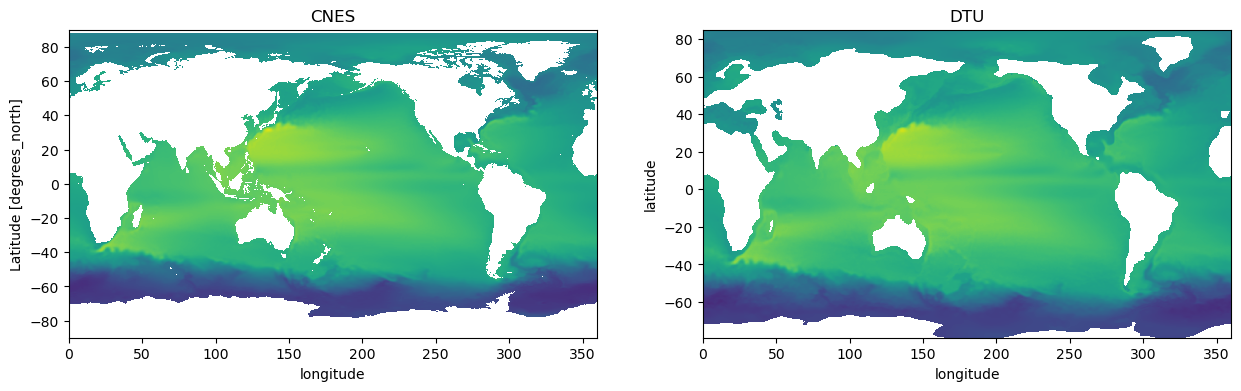

In [8]:
# plot each of the datasets
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
ds_obs_cnes.mdt.plot(ax=axs[0], vmin=-2, vmax=2, add_colorbar=False)
axs[0].set_title('CNES')
ds_obs_dtu.mdt.plot(ax=axs[1], vmin=-2, vmax=2, add_colorbar=False)
axs[1].set_title('DTU')

## Regrid to global grid and mask

In [9]:
rez=0.5 #grid resolution
destgrid=generate_global_grid(rez)

In [20]:
%%time
# # regrid datasets onto regular grid
regrid_cnes_rg = xe.Regridder(ds_obs_cnes, destgrid, "conservative_normed", periodic=True)#, extrap_method=None)
cnes_mdt_rg = regrid_cnes_rg(ds_obs_cnes.mdt) 
print("finished cnes")
regrid_dtu_rg = xe.Regridder(ds_obs_dtu, destgrid, "conservative_normed", periodic=True)#, extrap_method=None)
dtu_mdt_rg = regrid_dtu_rg(ds_obs_dtu.mdt) 

finished cnes
CPU times: user 1.38 s, sys: 63.2 ms, total: 1.44 s
Wall time: 2.28 s


Text(0.5, 1.0, 'DTU')

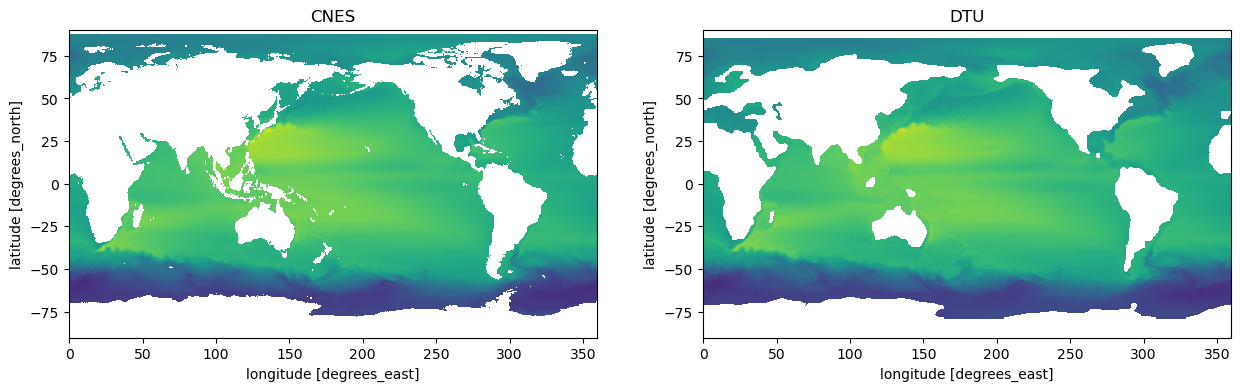

In [21]:
# plot each of the datasets
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
cnes_mdt_rg.plot(ax=axs[0], vmin=-2, vmax=2, add_colorbar=False)
axs[0].set_title('CNES')
dtu_mdt_rg.plot(ax=axs[1], vmin=-2, vmax=2, add_colorbar=False)
axs[1].set_title('DTU')

In [22]:
cnes_mdt_rg.name='mdt'
cnes_mdt_rg=cnes_mdt_rg.to_dataset()
cnes_mdt_rg=cnes_mdt_rg.assign(area=destgrid.area)
dtu_mdt_rg.name='mdt'
dtu_mdt_rg=dtu_mdt_rg.to_dataset()
dtu_mdt_rg=dtu_mdt_rg.assign(area=destgrid.area)

In [23]:
maxlat=70
cnes_mdt_rg = cnes_mdt_rg.sel(lat=slice(-maxlat,maxlat))
dtu_mdt_rg = dtu_mdt_rg.sel(lat=slice(-maxlat,maxlat))

Text(0.5, 1.0, 'DTU')

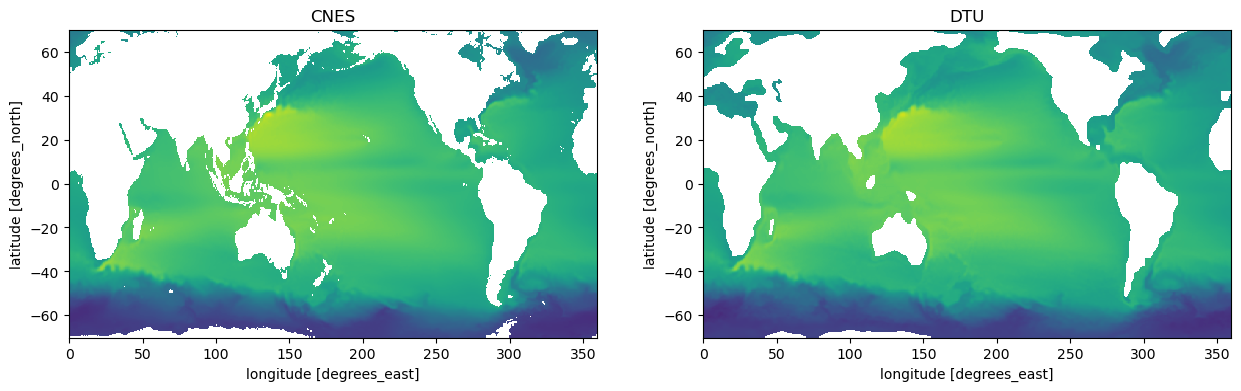

In [24]:
# plot each of the datasets
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
cnes_mdt_rg.mdt.plot(ax=axs[0], vmin=-2, vmax=2, add_colorbar=False)
axs[0].set_title('CNES')
dtu_mdt_rg.mdt.plot(ax=axs[1], vmin=-2, vmax=2, add_colorbar=False)
axs[1].set_title('DTU')

In [25]:
cnes_mdt_rg=cnes_mdt_rg.where(~np.isnan(dtu_mdt_rg.mdt)).where(~np.isnan(cnes_mdt_rg.mdt))
dtu_mdt_rg=dtu_mdt_rg.where(~np.isnan(dtu_mdt_rg.mdt)).where(~np.isnan(cnes_mdt_rg.mdt))

Text(0.5, 1.0, 'DTU')

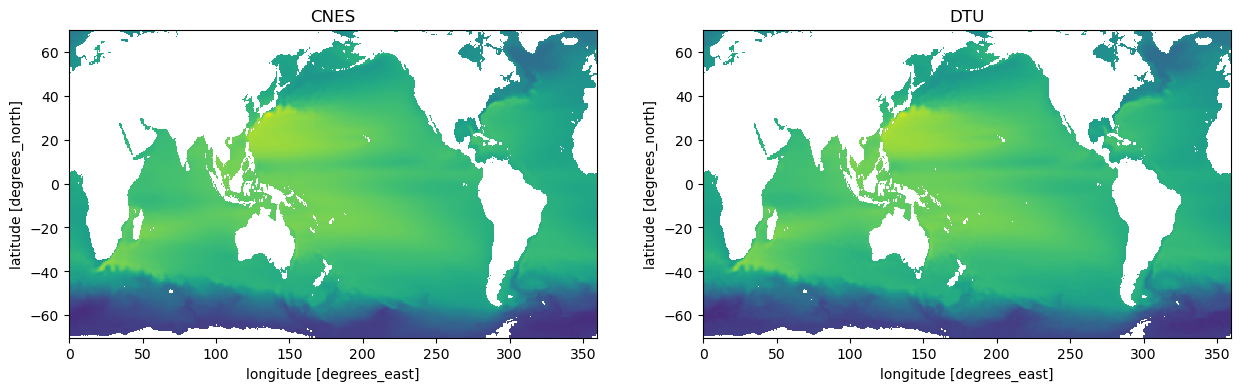

In [26]:
# plot each of the datasets
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
cnes_mdt_rg.mdt.plot(ax=axs[0], vmin=-2, vmax=2, add_colorbar=False)
axs[0].set_title('CNES')
dtu_mdt_rg.mdt.plot(ax=axs[1], vmin=-2, vmax=2, add_colorbar=False)
axs[1].set_title('DTU')

In [27]:
#remove mean
def horizontal_mean_no_wet(da, metrics, lsm):
    num = (da * metrics['area']).sum(dim=['lon', 'lat'])
    denom = (metrics['area'].where(lsm)).sum(dim=['lon', 'lat'])
    return num / denom

lsm = ~np.isnan(dtu_mdt_rg.mdt)
gm_dtu=horizontal_mean_no_wet(dtu_mdt_rg.mdt, destgrid, lsm)
gm_cnes=horizontal_mean_no_wet(cnes_mdt_rg.mdt, destgrid, lsm)
# gm_dtu=horizontal_mean_no_wet(dtu_mask_mom, ds_grid, lsm)
gm_dtu.values, gm_cnes.values

dtu_mdt_rg['mdt']=dtu_mdt_rg.mdt-gm_dtu
cnes_mdt_rg['mdt']=cnes_mdt_rg.mdt-gm_cnes

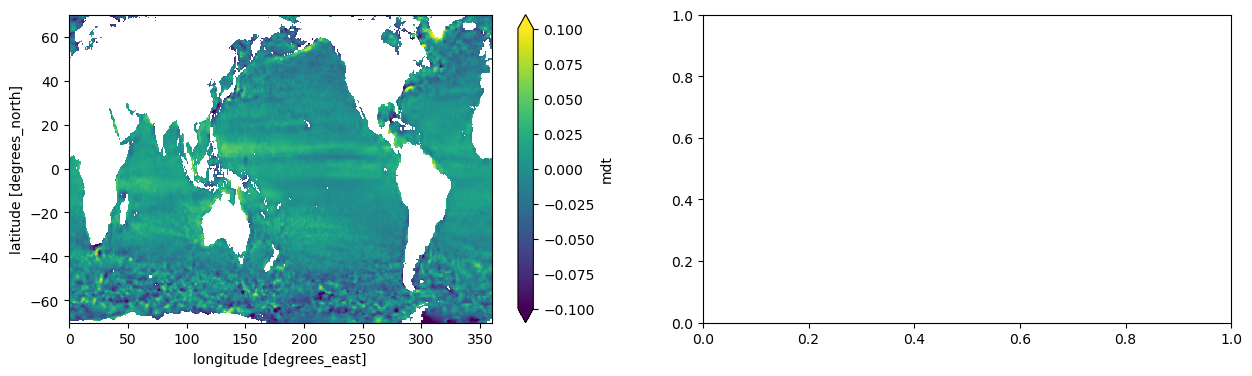

In [28]:
# plot each of the datasets
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
(cnes_mdt_rg.mdt-dtu_mdt_rg.mdt).plot(ax=axs[0], vmin=-.1, vmax=.1, add_colorbar=True)

In [29]:
# dtu_mdt_rg.to_netcdf(outputdir+'dtu_mdt_1deg.nc',mode='w')
# cnes_mdt_rg.to_netcdf(outputdir+'cnes_mdt_1deg.nc',mode='w')
dtu_mdt_rg.to_netcdf(outputdir+'dtu_mdt_p5deg.nc',mode='w')
cnes_mdt_rg.to_netcdf(outputdir+'cnes_mdt_p5deg.nc',mode='w')